In [16]:
%matplotlib widget

# Load and preprocess data
import torch
from torch import nn
import numpy as np

import os
import re

from prep_data import preprocess_data_3, get_all_outdoor_data, get_all_outdoor_data_batched

import random

# A seed of 2023 is needed for good_initialization.model to work; but the seed needs to only be set here (not in the later cells)
seed = 2023
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

batch_size = 100

# train_data, test_data = preprocess_data_3(17, 1, 16, 0.9, augment=True)
# train_data, test_data = preprocess_data_3(17, 1, 12, 0.9, augment=True)
train_data, test_data = get_all_outdoor_data_batched(1, 16, 0.9, batch_size, augment=True)

print(len(train_data))
print(len(test_data))

138
8


In [18]:
seed = 2023
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

mode = "train_initial_weights"
# mode = "tune_existing_weights"

def cuda_get_device():
	is_cuda = torch.cuda.is_available()
	if is_cuda:
		return torch.device("cuda")
	else:
		print("GPU not available, CPU used")
		return torch.device("cpu")

device = cuda_get_device()

class GRUModel(nn.Module):
	def __init__(self, input_size, output_size, hidden_dim, n_layers, GRU_dropout):
		super(GRUModel, self).__init__()
		self.hidden_dim = hidden_dim
		self.n_layers = n_layers
		self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_dim, dropout=GRU_dropout, batch_first=True)
		self.fc = nn.Linear(hidden_dim, output_size)
	
	def forward(self, x):
		hidden = self.gru(x)[0]
		# hidden = hidden.contiguous().view(-1, self.hidden_dim)
		out = self.fc(hidden)
		return out

# Model Hyperparameters
hidden_state_size = 12
fc_layers = 1
# 0.3 dropout appears to be better than 0.2
model = GRUModel(input_size=64, output_size=1, hidden_dim=hidden_state_size, n_layers=fc_layers, GRU_dropout=0.3)

if mode == "train_initial_weights":
	n_epochs = 2000
	lr = 0.03
else:
	n_epochs = 50
	lr=0.001
	model.load_state_dict(torch.load("C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\saved_parameters\\augment_initialization.model"))

model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
milestones = [230, 500, 1100]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.4)

# Training Run
loss_sequence = []
for epoch in range(1, n_epochs + 1):
	epoch_losses = torch.tensor([0],dtype=float).to(device)
	for data in train_data:
		optimizer.zero_grad()
		# input_data = torch.from_numpy(data[0]).float().to(device)
		input_data = data[0].float().to(device)
		# target_pred = torch.from_numpy(data[1]).unsqueeze(0).float().to(device)
		target_pred = data[1].unsqueeze(1).float().to(device)
		output = model(input_data)[:,-1,:]
		loss = criterion(output, target_pred)
		loss.backward()
		optimizer.step()
		epoch_losses += loss
	scheduler.step()
	loss_sequence.append(epoch_losses.to('cpu').item())
	if epoch%5 == 0:
		print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
		print("Loss: {:.4f}".format(epoch_losses.to('cpu').item()))

Epoch: 5/2000............. Loss: 83.7500
Epoch: 10/2000............. Loss: 74.0490
Epoch: 15/2000............. Loss: 81.7025
Epoch: 20/2000............. Loss: 72.5344
Epoch: 25/2000............. Loss: 69.5805
Epoch: 30/2000............. Loss: 66.1620
Epoch: 35/2000............. Loss: 64.3396
Epoch: 40/2000............. Loss: 62.8289
Epoch: 45/2000............. Loss: 62.4421
Epoch: 50/2000............. Loss: 61.9000
Epoch: 55/2000............. Loss: 61.7969
Epoch: 60/2000............. Loss: 61.4017
Epoch: 65/2000............. Loss: 61.4199
Epoch: 70/2000............. Loss: 61.5396
Epoch: 75/2000............. Loss: 59.7559
Epoch: 80/2000............. Loss: 59.8901
Epoch: 85/2000............. Loss: 59.4174
Epoch: 90/2000............. Loss: 58.9304
Epoch: 95/2000............. Loss: 59.1888
Epoch: 100/2000............. Loss: 58.6189
Epoch: 105/2000............. Loss: 58.1690
Epoch: 110/2000............. Loss: 58.0491
Epoch: 115/2000............. Loss: 57.8166
Epoch: 120/2000............. Lo

KeyboardInterrupt: 

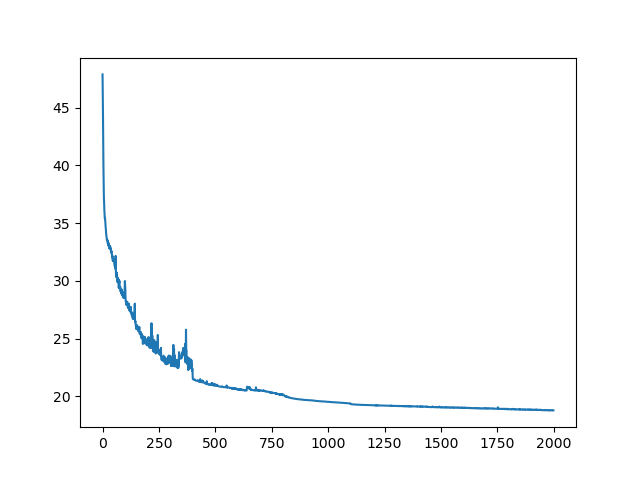

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_sequence)
plt.show()

In [10]:
torch.save(model.state_dict(),"C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\saved_parameters\\augment_initialization.model")

In [14]:
import matplotlib.pyplot as plt

other_train_data, other_test_data = get_all_outdoor_data(1, 16, 0.9)

predictions = []
targets = []
with torch.no_grad():
	for data in other_train_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(targets_numpy))
print(np.sum(pred))

# 18.8 loss, 425 incorrect

433
1724
1529


In [15]:
# Evaluate on the test dataset
model.eval()

predictions = []
targets = []
with torch.no_grad():
	for data in other_test_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(pred))
print(np.sum(targets_numpy))

# print(np.where(test_targets != pred))
# print(np.where(np.abs(test_targets-pred) != 0))

75
158
195


In [8]:
# Test using a larger test dataset
from prep_data import get_all_outdoor_data

# train_data, test_data = get_all_outdoor_data(1, 16, 0.9)
train_data, test_data = get_all_outdoor_data(1, 12, 0.9)

In [9]:
predictions = []
targets = []
with torch.no_grad():
	for data in test_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(pred))
print(np.sum(targets_numpy))

183
346
203
